# Import Packages

In [7]:
import os
import sys
import csv
import random
import platform
import subprocess

# Set Command

In [3]:
os_name = platform.system()
if os_name == "Darwin":
    ECDSA_command = "./ECDSA-macOS"
    ECDSA_ResultFile = "ECDSA_macOS.csv"
elif os_name == "Linux":
    ECDSA_command = "./ECDSA-Linux"
    ECDSA_ResultFile = "ECDSA_Linux.csv"
elif os_name == "Windows":
    ECDSA_command = "ECDSA-Windows.exe"
    ECDSA_ResultFile = "ECDSA_Windows.csv"
else:
    print("OS not supported")
    sys.exit(1)

if not os.path.exists(ECDSA_command):
    print("Please compile the C++ code first")
    sys.exit(1)

print("ECDSA command: ", ECDSA_command)
print("ECDSA Result File: ", ECDSA_ResultFile)

ECDSA command:  ./ECDSA-Linux
ECDSA Result File:  ECDSA_Linux.csv


# Create Input Files

In [ ]:
# Create directories
if not os.path.exists("./Container"):
    os.makedirs("./Container")
if not os.path.exists("./Container/Key"):
    os.makedirs("./Container/Key")
if not os.path.exists("./Container/Plain"):
    os.makedirs("./Container/Plain")
if not os.path.exists("./Container/Signature"):
    os.makedirs("./Container/Signature")
    
# Create a file with random data
def create_file(file_path, size_in_bytes):
    with open(file_path, 'wb') as f:
        random_bytes = bytearray(os.urandom(size_in_bytes))
        for i in range(size_in_bytes):
            random_bytes[i] = random.randint(65, 122)  # ASCII characters from space to tilde
        f.write(random_bytes)

# Create files with sizes from 1MB to 1GB
sizes = [1024*1024, 16*1024*1024, 32*1024*1024, 64*1024*1024, 128*1024*1024]

for size in sizes:
    FileName = f"{size // 1048576}MB.txt"
    FilePath = "./Container/Plain/" + FileName
    create_file(FilePath, size)
    print(f"File {FileName} created.")

# Run ECDSA Test

In [ ]:
PlainDirectory = "./Container/Plain/"
KeyDirectory = "./Container/Key/"
SignatureDirectory = "./Container/Signature/"

InputFiles = ["1MB.txt", "16MB.txt", "32MB.txt", "64MB.txt", "128MB.txt"]
Formats = ["DER", "PEM"]
defaultloops = 100

def KeyGeneration(Format):
    if Format == "DER":
        KeyCommand = f"{ECDSA_command} keygen {KeyDirectory}private.der {KeyDirectory}public.der {Format}"
    elif Format == "PEM":
        KeyCommand = f"{ECDSA_command} keygen {KeyDirectory}private.pem {KeyDirectory}public.pem {Format}"

    process = subprocess.Popen(KeyCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    KeyTime = output.decode("utf-8")
    KeyError = error.decode("utf-8")
    return KeyTime, KeyError

def ECDSA_Execution(PrivateKey, PublicKey, File):
    SignCommand = f"{ECDSA_command} sign {KeyDirectory + PrivateKey} {PlainDirectory + File} {SignatureDirectory}Sign_{File}"
    VerifyCommand = f"{ECDSA_command} verify {KeyDirectory + PublicKey} {PlainDirectory + File} {SignatureDirectory}Sign_{File}"
    process = subprocess.Popen(SignCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    SignTime = output.decode("utf-8")
    SignError = error.decode("utf-8")
    
    process = subprocess.Popen(VerifyCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    VerifyTime = output.decode("utf-8")
    VerifyError = error.decode("utf-8")

    return SignTime, SignError, VerifyTime, VerifyError

print("Start ECDSA test...")
with open(ECDSA_ResultFile, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Algorithm", "Format", "File", "SignTime", "VerifyTime"])
    
    for File in InputFiles:
        for Format in Formats:
            print(f"[ {Format} | {File} ]")
            KeyTime, KeyError = KeyGeneration(Format)
            if KeyError:
                print(f"Error: {KeyError}")
                sys.exit(1)
            i = 0
            while i < defaultloops:
                if Format == "DER":
                    SignTime, SignError, VerifyTime, VerifyError = ECDSA_Execution("private.der", "public.der", File)
                elif Format == "PEM":
                    SignTime, SignError, VerifyTime, VerifyError = ECDSA_Execution("private.pem", "public.pem", File)
                if SignError or VerifyError:
                    print(f"Error: {SignError} {VerifyError}")
                    sys.exit(1)
                writer.writerow(["ECDSA", Format, File, SignTime, VerifyTime])
                i = i + 1
            print(f"ECDSA for file {File} with format {Format} is completed.")
            
print("Successfully run ECDSA test!")

# Compare the results of the different OS and Input Sizes

Results for Linux:
   OS InputSize  SignTime_mean  VerifyTime_mean
Linux   1MB.txt          0.014            0.012
Linux  16MB.txt          0.145            0.141
Linux  32MB.txt          0.287            0.286
Linux  64MB.txt          0.576            0.572
Linux 128MB.txt          1.106            1.100



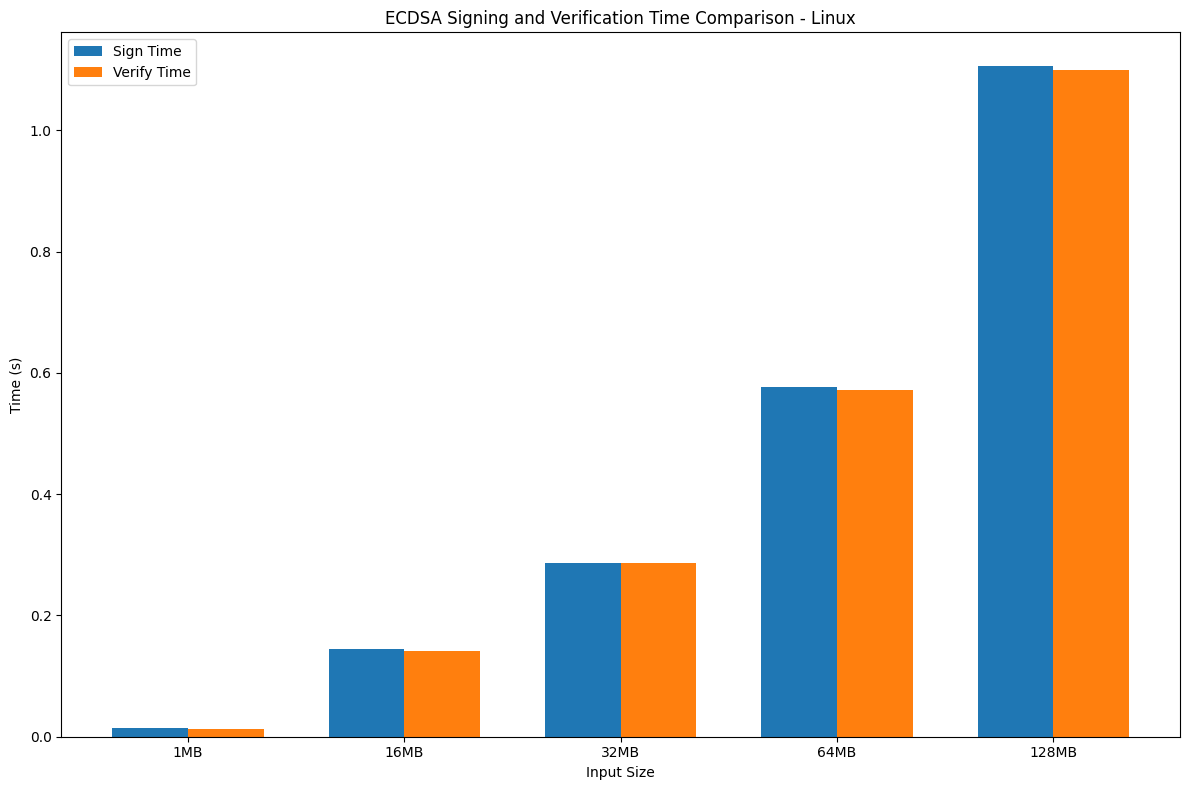

Results for macOS:
   OS InputSize  SignTime_mean  VerifyTime_mean
macOS   1MB.txt          0.004            0.004
macOS  16MB.txt          0.052            0.054
macOS  32MB.txt          0.103            0.107
macOS  64MB.txt          0.207            0.214
macOS 128MB.txt          0.423            0.442



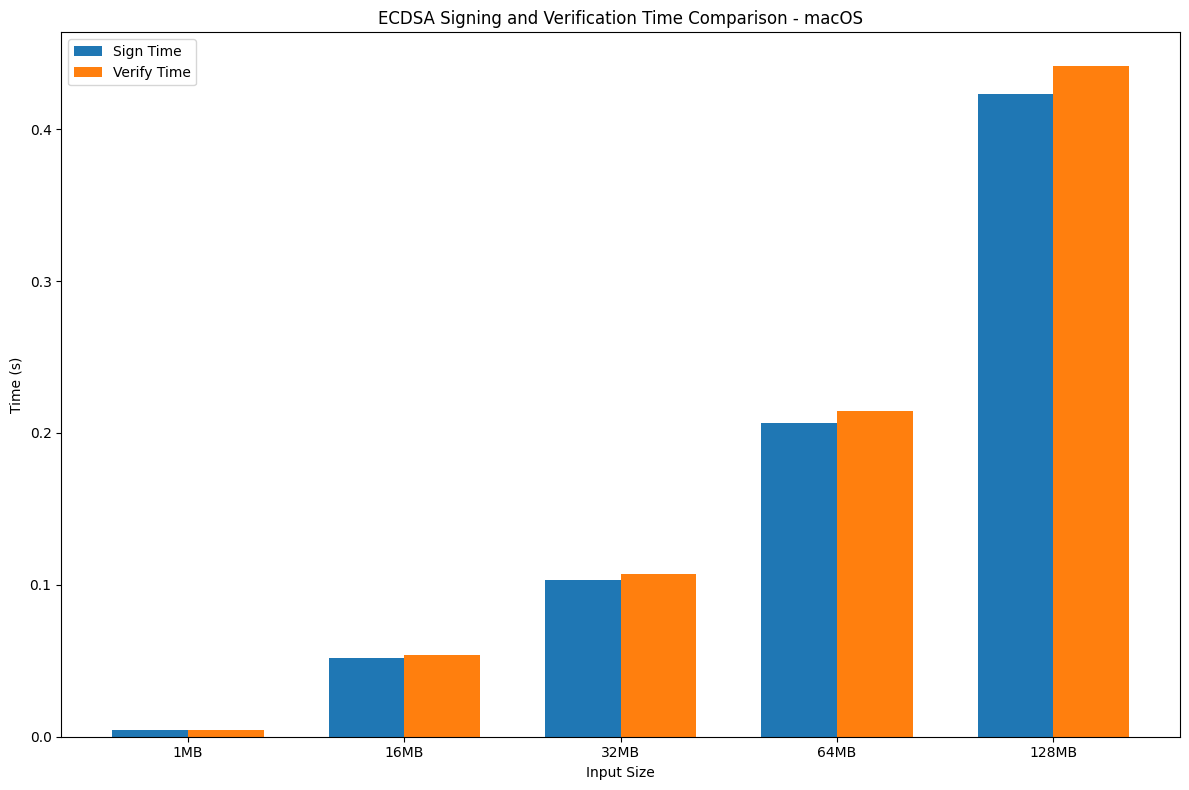

Results for Windows:
     OS InputSize  SignTime_mean  VerifyTime_mean
Windows   1MB.txt          0.013            0.012
Windows  16MB.txt          0.097            0.098
Windows  32MB.txt          0.183            0.182
Windows  64MB.txt          0.367            0.370
Windows 128MB.txt          0.738            0.746



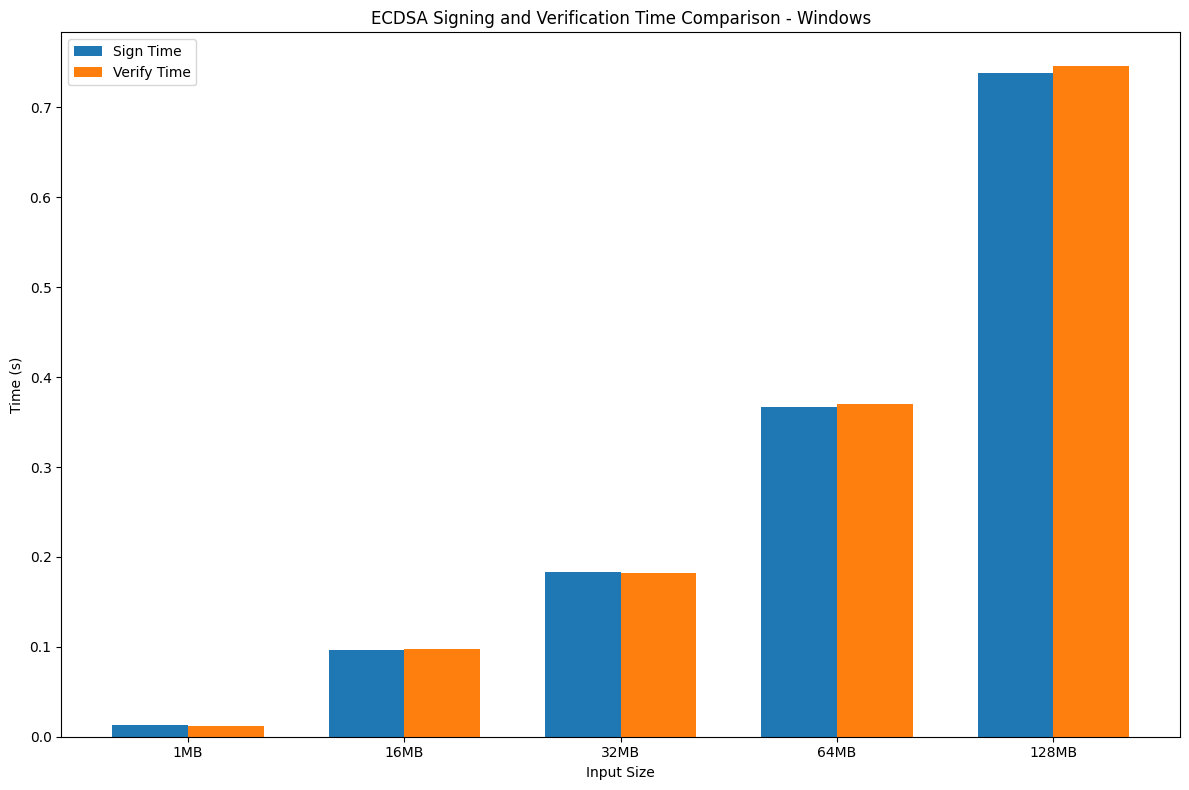

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV files containing the results of the ECDSA tests
files = {
    "ECDSA_Linux": "ECDSA_Linux.csv",
    "ECDSA_macOS": "ECDSA_macOS.csv",
    "ECDSA_Windows": "ECDSA_Windows.csv"
}

InputFiles = ["1MB.txt", "16MB.txt", "32MB.txt", "64MB.txt", "128MB.txt"]

# Initialize a DataFrame to store the results
results_list = []

# Read the results from the CSV files
for label, file_path in files.items():
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        df = pd.read_csv(file_path)
        os_name = label.split('_')[1]

        # Loop through each input file
        for input_file in InputFiles:
            # Filter data based on the 'File' column
            input_os_df = df[df['File'] == input_file]

            if not input_os_df.empty:
                sign_mean = input_os_df['SignTime'].mean()
                verify_mean = input_os_df['VerifyTime'].mean()
                results_list.append({
                    'OS': os_name,
                    'InputSize': input_file,
                    'SignTime_mean': sign_mean,
                    'VerifyTime_mean': verify_mean
                })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Plot function
def plot_results(df, title):
    if df.empty:
        print("No data available.")
        return

    os_list = df['OS'].unique()
    input_sizes = [size.replace('.txt', '') for size in InputFiles]

    for os_name in os_list:
        os_df = df[df['OS'] == os_name]

        if os_df.empty:
            print(f"No data available for {os_name}.")
            continue

        print(f"Results for {os_name}:")
        print(os_df.to_string(index=False, float_format="{:.3f}".format))
        print()

        plt.figure(figsize=(12, 8))

        sign_y = os_df['SignTime_mean'].values
        verify_y = os_df['VerifyTime_mean'].values

        x = np.arange(len(input_sizes))
        width = 0.35  # Width of the bars

        plt.bar(x - width/2, sign_y, width, label='Sign Time', color='#1f77b4')   # Blue
        plt.bar(x + width/2, verify_y, width, label='Verify Time', color='#ff7f0e')  # Orange

        plt.xlabel('Input Size')
        plt.ylabel('Time (s)')
        plt.title(f'{title} - {os_name}')
        plt.xticks(x, input_sizes)
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(results_df, 'ECDSA Signing and Verification Time Comparison')
